# Convolution Image Net

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import shutil
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from PIL import Image
from utils.nn_graph import simple_layer
from utils.data import init_dir

## Load data

In [3]:
data = input_data.read_data_sets('/data/fashion/', one_hot=True)
img_shape = (28, 28)
class_id2class_name_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

Extracting /data/fashion/train-images-idx3-ubyte.gz
Extracting /data/fashion/train-labels-idx1-ubyte.gz
Extracting /data/fashion/t10k-images-idx3-ubyte.gz
Extracting /data/fashion/t10k-labels-idx1-ubyte.gz


## Build Conv Net Graph

In [4]:
from utils.nn_visualization import conv33132_summaries, conv55124_summary, variable_summaries

In [6]:
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('conv_image_net_inputs'):
        images = tf.placeholder(tf.float32, shape=[None, 784], name='images')
        labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')
        keep_dropout_prob = tf.placeholder(tf.float32, name='keep_dropout_prob')
        is_training = tf.placeholder(tf.bool, name='is_training')
            
    with tf.name_scope('image_reshape'):        
        images_reshaped = tf.reshape(images, [-1, 28, 28, 1])

    with tf.variable_scope('conv_layer_1'):
        pass
        #######################################################
        # conv layer, 32 filters (3, 3), stride (1, 1), SAME  #
        # bias, relu                                          #
        # max pooling, (2, 2), stride (2, 2), SAME            # 
        #######################################################

    with tf.variable_scope('conv_layer_2'):
        pass
        #######################################################
        # conv layer, 64 filters (3, 3), stride (1, 1), SAME  #
        # bias, relu                                          #
        # max pooling, (2, 2), stride (2, 2), SAME            # 
        #######################################################
    
    with tf.variable_scope('feed_forward_layer_1'):
        raw_prediction = tf.reshape(images_reshaped, [-1, 28 * 28])
        raw_prediction = simple_layer('ff_1', raw_prediction, shape=[28 * 28, 10], activation='linear')
        raw_prediction = tf.nn.dropout(raw_prediction, keep_dropout_prob)

    with tf.name_scope('prediction'):
        prediction = tf.nn.softmax(raw_prediction)
    
    with tf.variable_scope("embedding_visualization"):
        embedding = tf.Variable(tf.zeros([5000, 10]), name='valid_embedding')
        embedding_assignment = embedding.assign(raw_prediction)

    with tf.name_scope('loss'):
        cross_entropy_vector = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=raw_prediction)
        loss = tf.reduce_mean(cross_entropy_vector)
        variable_summaries('loss_summary', cross_entropy_vector)
        
    with tf.name_scope('training'):
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_step  = tf.train.AdamOptimizer(1e-4).minimize(loss)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)
        variable_summaries('accuracy_summary', correct_prediction)
    
    initialize_vars = tf.global_variables_initializer()
    merge_summaries = tf.summary.merge_all()

## Init Model Logging

In [7]:
from utils.data import init_model_logging
base_dir = '/tensorboard_summaries/conv_image_net/'
exp_name = 'experiment_1'

logging_meta = init_model_logging(base_dir, exp_name, graph=graph, remove_existing=True)

## Add Embedding Projection

In [8]:
from utils.nn_visualization import init_embedding_projector, init_embedding_data
from utils.nn_visualization import get_sprite_img, get_label_class_names

sprite_img = get_sprite_img(data.validation.images, img_shape)
label_names = get_label_class_names(data.validation.labels, class_id2class_name_mapping)

init_embedding_data(logging_meta['valid_writer_dir'], sprite_img, label_names)
init_embedding_projector(logging_meta['valid_writer'], embedding, img_shape)

## Run Conv Net

In [9]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
model_path = logging_meta['model_path']

validation_feed_dict = {
    images: data.validation.images, 
    labels: data.validation.labels,
    keep_dropout_prob: 1., 
    is_training: False}

with tf.Session(graph=graph, config=config) as session:
    session.run(initialize_vars)
    for iteration in range(5000):
        ##################
        # Training phase #
        ##################
        _images, _labels = data.train.next_batch(100)
        feed_dict = {images: _images, labels: _labels, keep_dropout_prob: 0.5, is_training: True}
        _ = session.run([train_step], feed_dict=feed_dict)
        
        if iteration % 10 == 0:
            feed_dict={images: _images, labels: _labels, keep_dropout_prob: 1., is_training: False}
            _summary, _accuracy, _loss = session.run([merge_summaries, accuracy, loss],feed_dict=feed_dict)
            
            logging_meta['train_writer'].add_summary(_summary, iteration)
            print("Train Iteration {}: loss {}, accuracy {}".format(iteration, _loss, _accuracy))
      
        ####################
        # Validation phase #
        ####################
        if iteration % 100 == 0:
            fetches = [embedding_assignment, merge_summaries, accuracy, loss]
            _, _summary, _accuracy, _loss = session.run(fetches, validation_feed_dict)
            
            logging_meta['valid_writer'].add_summary(_summary, iteration)
            logging_meta['saver'].save(session, model_path, iteration)
            print("= Valid Iteration {}: loss {}, accuracy {} =".format(iteration, _loss, _accuracy))
            
    _prediction, = session.run([prediction], feed_dict=validation_feed_dict)

Train Iteration 0: loss 2.239495038986206, accuracy 0.18000000715255737
= Valid Iteration 0: loss 2.3501458168029785, accuracy 0.1534000039100647 =
Train Iteration 10: loss 2.278409719467163, accuracy 0.18000000715255737
Train Iteration 20: loss 2.140306234359741, accuracy 0.25999999046325684
Train Iteration 30: loss 2.059706211090088, accuracy 0.27000001072883606
Train Iteration 40: loss 2.02481746673584, accuracy 0.28999999165534973
Train Iteration 50: loss 1.9637298583984375, accuracy 0.3700000047683716
Train Iteration 60: loss 1.965499997138977, accuracy 0.41999998688697815
Train Iteration 70: loss 1.8631497621536255, accuracy 0.5299999713897705
Train Iteration 80: loss 1.8721674680709839, accuracy 0.4699999988079071
Train Iteration 90: loss 1.793980360031128, accuracy 0.47999998927116394
Train Iteration 100: loss 1.8072885274887085, accuracy 0.49000000953674316
= Valid Iteration 100: loss 1.7790640592575073, accuracy 0.5023999810218811 =
Train Iteration 110: loss 1.744497179985046

= Valid Iteration 1100: loss 0.9774163961410522, accuracy 0.7540000081062317 =
Train Iteration 1110: loss 0.9267878532409668, accuracy 0.7699999809265137
Train Iteration 1120: loss 0.9965568780899048, accuracy 0.7400000095367432
Train Iteration 1130: loss 1.1432615518569946, accuracy 0.6800000071525574
Train Iteration 1140: loss 0.9908093214035034, accuracy 0.7699999809265137
Train Iteration 1150: loss 0.9301577806472778, accuracy 0.7300000190734863
Train Iteration 1160: loss 0.9622480869293213, accuracy 0.7099999785423279
Train Iteration 1170: loss 0.9150447249412537, accuracy 0.8199999928474426
Train Iteration 1180: loss 1.0638997554779053, accuracy 0.699999988079071
Train Iteration 1190: loss 0.9884846210479736, accuracy 0.75
Train Iteration 1200: loss 1.038170337677002, accuracy 0.7300000190734863
= Valid Iteration 1200: loss 0.9578579068183899, accuracy 0.7595999836921692 =
Train Iteration 1210: loss 0.9483897686004639, accuracy 0.7400000095367432
Train Iteration 1220: loss 0.9978

Train Iteration 2120: loss 0.804289698600769, accuracy 0.800000011920929
Train Iteration 2130: loss 0.806663990020752, accuracy 0.7799999713897705
Train Iteration 2140: loss 0.7575244903564453, accuracy 0.8600000143051147
Train Iteration 2150: loss 0.8726539611816406, accuracy 0.7599999904632568
Train Iteration 2160: loss 0.8068969249725342, accuracy 0.7799999713897705
Train Iteration 2170: loss 0.799573540687561, accuracy 0.8299999833106995
Train Iteration 2180: loss 0.8812329173088074, accuracy 0.75
Train Iteration 2190: loss 0.736710786819458, accuracy 0.8600000143051147
Train Iteration 2200: loss 0.8028666973114014, accuracy 0.7900000214576721
= Valid Iteration 2200: loss 0.8130978345870972, accuracy 0.7932000160217285 =
Train Iteration 2210: loss 0.9081564545631409, accuracy 0.7099999785423279
Train Iteration 2220: loss 0.8709741234779358, accuracy 0.7699999809265137
Train Iteration 2230: loss 0.9108283519744873, accuracy 0.7900000214576721
Train Iteration 2240: loss 0.85800623893

= Valid Iteration 3200: loss 0.739193856716156, accuracy 0.8090000152587891 =
Train Iteration 3210: loss 0.7607086300849915, accuracy 0.7799999713897705
Train Iteration 3220: loss 0.741008460521698, accuracy 0.8199999928474426
Train Iteration 3230: loss 0.5553848743438721, accuracy 0.8799999952316284
Train Iteration 3240: loss 0.6579962372779846, accuracy 0.8899999856948853
Train Iteration 3250: loss 0.7730616927146912, accuracy 0.7699999809265137
Train Iteration 3260: loss 0.7341157793998718, accuracy 0.8299999833106995
Train Iteration 3270: loss 0.6836990118026733, accuracy 0.8600000143051147
Train Iteration 3280: loss 0.7181665897369385, accuracy 0.7900000214576721
Train Iteration 3290: loss 0.7253707647323608, accuracy 0.8100000023841858
Train Iteration 3300: loss 0.7212574481964111, accuracy 0.8199999928474426
= Valid Iteration 3300: loss 0.7352574467658997, accuracy 0.8077999949455261 =
Train Iteration 3310: loss 0.8427821397781372, accuracy 0.7699999809265137
Train Iteration 332

Train Iteration 4340: loss 0.710224986076355, accuracy 0.800000011920929
Train Iteration 4350: loss 0.7339739799499512, accuracy 0.7799999713897705
Train Iteration 4360: loss 0.7341633439064026, accuracy 0.7900000214576721
Train Iteration 4370: loss 0.8098574876785278, accuracy 0.7300000190734863
Train Iteration 4380: loss 0.8115984201431274, accuracy 0.800000011920929
Train Iteration 4390: loss 0.700376033782959, accuracy 0.7699999809265137
Train Iteration 4400: loss 0.686882495880127, accuracy 0.8199999928474426
= Valid Iteration 4400: loss 0.6840372085571289, accuracy 0.8181999921798706 =
Train Iteration 4410: loss 0.6542320251464844, accuracy 0.8500000238418579
Train Iteration 4420: loss 0.6827006340026855, accuracy 0.8500000238418579
Train Iteration 4430: loss 0.7129707336425781, accuracy 0.8399999737739563
Train Iteration 4440: loss 0.6556123495101929, accuracy 0.8600000143051147
Train Iteration 4450: loss 0.7741818428039551, accuracy 0.8100000023841858
Train Iteration 4460: loss

## Results evaluation

In [10]:
from utils.results_evaluation import get_info_df
from utils.results_evaluation import get_accuracy
from utils.results_evaluation import get_false_positives
from utils.results_evaluation import get_info_df
from utils.results_evaluation import get_rec_prec
from utils.results_evaluation import plot_coocurance_matrix
from utils.results_evaluation import plot_examples 

In [11]:
df = get_info_df(data.validation.labels, _prediction, class_id2class_name_mapping, data.validation.images)

In [12]:
get_accuracy(df)

82.2

In [13]:
get_accuracy(df, True)

97.42

In [14]:
get_rec_prec(df, class_id2class_name_mapping)

,class_name,precision,recall
0,T-shirt/top,74.16,82.28
1,Trouser,96.70,94.96
2,Pullover,74.89,69.25
3,Dress,80.07,88.22
4,Coat,66.23,82.79
5,Sandal,94.63,82.15
6,Shirt,72.38,41.99
7,Sneaker,85.71,91.41
8,Bag,89.02,95.92
9,Ankle boot,86.82,91.11


In [17]:
fp = get_false_positives(df, 'Shirt', 'Bag')

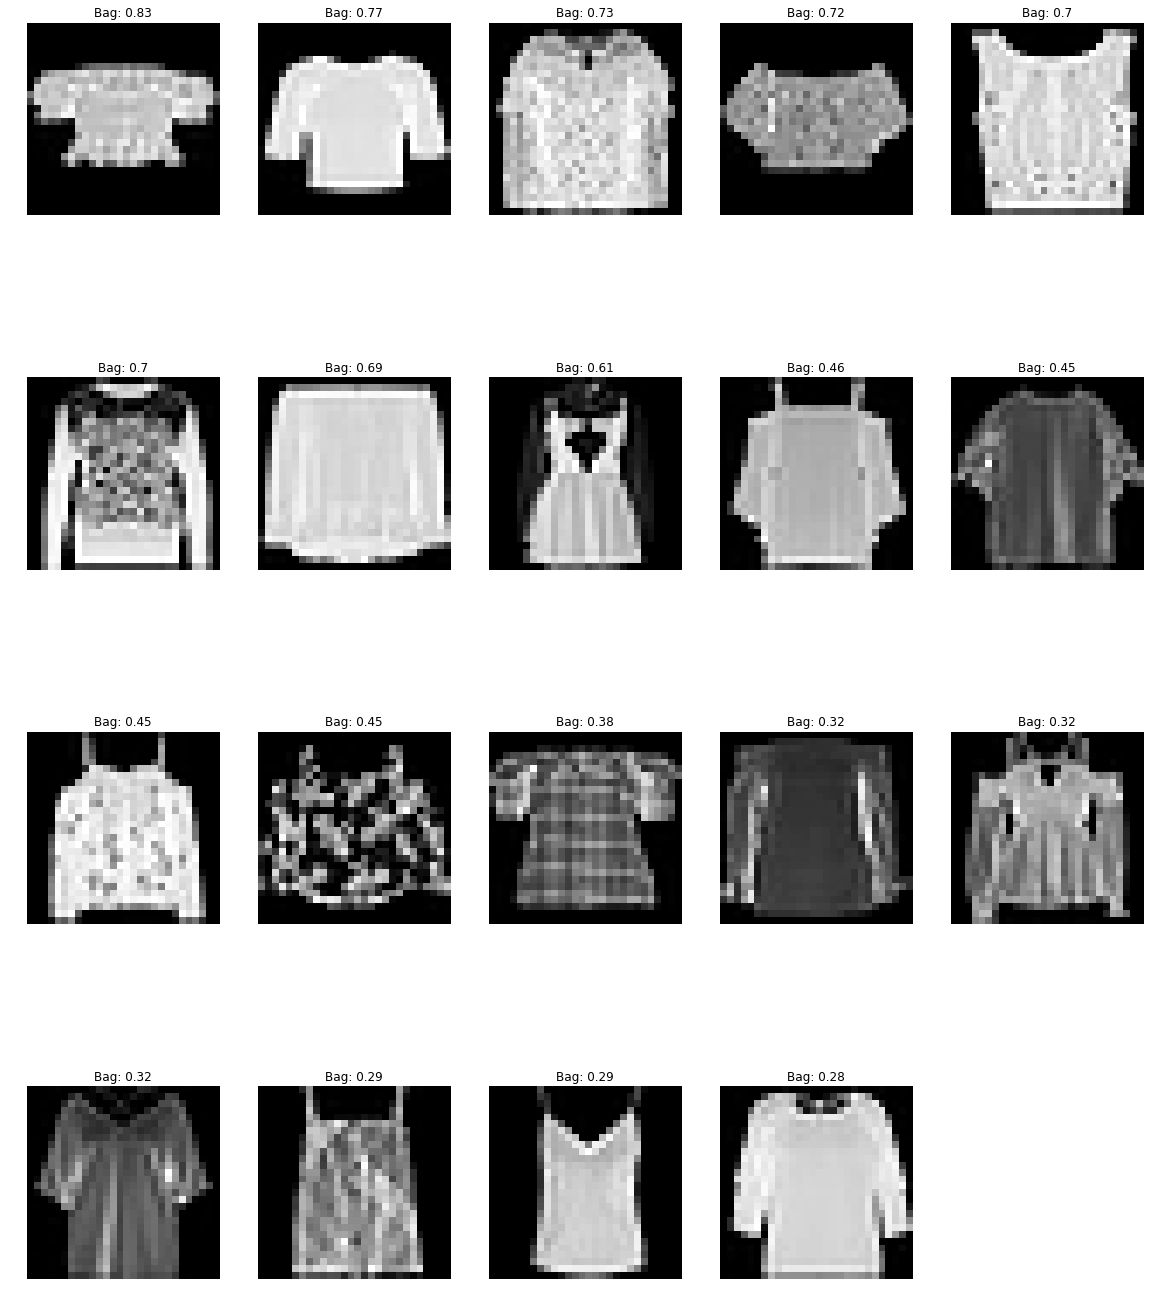

In [18]:
plot_examples(fp)

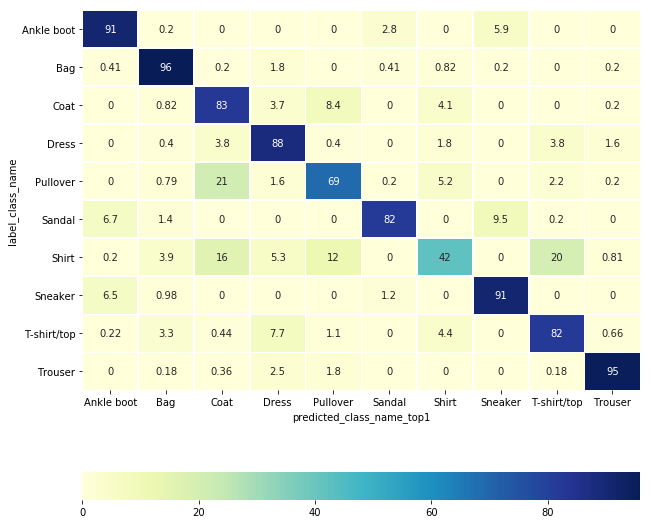

In [19]:
plot_coocurance_matrix(df, use_top3=False, use_log=False)